<a href="https://colab.research.google.com/github/tysonbarreto/GANs/blob/main/ImageGeneration_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opendatasets

In [86]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid, save_image

from tqdm.auto import tqdm
from IPython.display import Image
import cv2

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [4]:
PATH = '/content/animefacedataset'

In [5]:
os.listdir(PATH)

['images']

In [6]:
print('No of images:',len(os.listdir(PATH+'/images')))

No of images: 63565


*Resize the images to 64 x 64 px and normalize the lixel values with the mean and std of 0.5 for each channel (RGB) so as to ensure the pixels are in range of (-1,1), for the convenience of the discriminator*

In [7]:
BATCH_SIZE = 128
IMAGE_SIZE = 64
stats = (0.5,0.5,0.5), (0.5,0.5,0.5)

In [8]:
train_ds = ImageFolder(PATH, transform=T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize(*stats)
]))

In [9]:
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

In [10]:
for image, label in train_dl:
  test = image, label
  break

In [11]:
image = test[0]*stats[1][0] + stats[0][0]

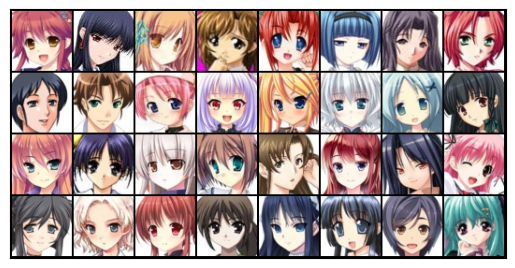

In [12]:
plt.imshow(make_grid(image.detach()[:32],nrow=8).permute(1,2,0))
plt.xticks([])
plt.yticks([])
plt.show()

In [13]:
def get_images(image_tensor, n_images=48, stats=stats)->None:
  image_tensor=image_tensor*stats[1][0] + stats[0][0]
  plt.imshow(make_grid(image_tensor.detach()[:n_images],nrow=8).permute(1,2,0))
  plt.xticks([])
  plt.yticks([])
  plt.show()


In [14]:
for image, label in train_dl:
  test = image, label
  break

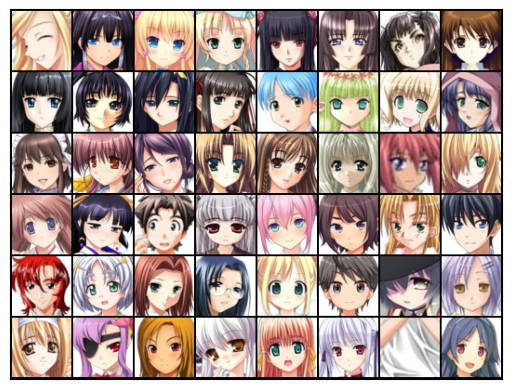

In [15]:
get_images(test[0])

## Setup GPU

In [16]:
class DeviceDataloader():

  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)

  def __len__(self):
    return len(self.dl)


In [17]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(d, device) for d in data]
  return data.to(device, non_blocking=True)

def set_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')


In [18]:
device = set_device()

In [19]:
train_dl = DeviceDataloader(train_dl, device)

## Build Discriminator Network
* To classify whether the image is real or fake
* Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient

In [49]:
DISCRIMINATOR = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())
DISCRIMINATOR = to_device(DESCRIMINATOR, device)

In [50]:
for batch in train_dl:
  out= DISCRIMINATOR(batch[0])
  break

In [51]:
out.size()

torch.Size([128, 1])

In [52]:
out.flatten().size()

torch.Size([128])

## Build Generator Network
* The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape (128, 1, 1) into an image tensor of shape 3 x 28 x 28. To achive this, we'll use the ConvTranspose2d layer from PyTorch, which performs as a transposed convolution (also referred to as a deconvolution).

In [53]:
LATENT_SIZE = 128


GENERATOR = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

GENERATOR = to_device(GENERATOR, device)

In [54]:
out= GENERATOR(torch.ones(BATCH_SIZE, LATENT_SIZE, 1,1, device=device))
out.size()

torch.Size([128, 3, 64, 64])

In [55]:
fake_image = GENERATOR(torch.randn(BATCH_SIZE, LATENT_SIZE, 1,1, device=device))


In [56]:
GENERATOR(torch.randn(BATCH_SIZE, LATENT_SIZE, 1,1, device=device))[0].size()

torch.Size([3, 64, 64])

## Discriminator Training

* Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

In [57]:
OPT_D = torch.optim.Adam(DESCRIMINATOR.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [67]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = DISCRIMINATOR(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
    fake_images = GENERATOR(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = DISCRIMINATOR(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [74]:
train_discriminator(batch[0], OPT_D)

(0.00034951974521391094, 0.9999819397926331, 0.0003313911729492247)

In [75]:
################################################################################
#We expect the discriminator to output 1 if the image was picked from the real dataset, and 0 if it was generated using the generator network.

#We first pass a batch of real images, and compute the loss, setting the target labels to 1.

#Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0.

#Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.
################################################################################

## Generator Training

In [76]:
OPT_G = torch.optim.Adam(GENERATOR.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [77]:
DESCRIMINATOR(batch[0]).mean()

tensor(1.0000, device='cuda:0', grad_fn=<MeanBackward0>)

In [78]:
def train_generator(OPT_G):
  OPT_G.zero_grad()

  latent = torch.randn(BATCH_SIZE, LATENT_SIZE, 1, 1, device=device)
  fake_image = GENERATOR(latent)
  fake_pred = DESCRIMINATOR(fake_image)
  fake_target = torch.ones(BATCH_SIZE, 1, device=device)
  loss = F.binary_cross_entropy(fake_pred, fake_target)

  loss.backward()
  OPT_G.step()
  return loss.item()


## Save image on its generated

In [79]:
def denorm(image_tensor):
  return image_tensor * stats[1][0] + stats[0][0]

In [80]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [81]:
def save_samples(index, latent_tensors, show=True):
  fake_image = GENERATOR(latent_tensors)
  fake_fname = f'generated_images - {index:0=4d}.png'
  save_image(denorm(fake_image), os.path.join(sample_dir,fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    image_tensor=denorm(fake_image)
    plt.imshow(make_grid(image_tensor.cpu().detach()[:64],nrow=8).permute(1,2,0))
    plt.xticks([])
    plt.yticks([])
    plt.show()


In [82]:
fixed_latent = torch.randn(64, LATENT_SIZE, 1, 1, device=device)

Saving generated_images - 0010.png


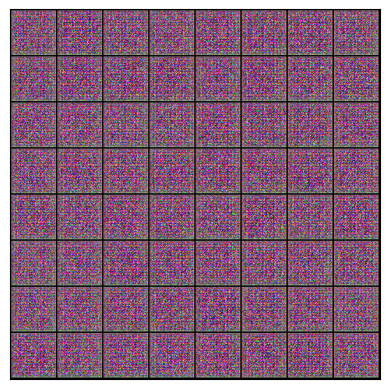

In [83]:
save_samples(10, fixed_latent)

In [84]:
## Full Training Loop

In [85]:
fixed_latent = torch.randn(64, LATENT_SIZE, 1, 1, device=device)
torch.cuda.empty_cache()

losses_g = []
losses_d = []

real_scores = []
fake_scores = []

OPT_D = torch.optim.Adam(DESCRIMINATOR.parameters(), lr=0.0002, betas=(0.5, 0.999))
OPT_G = torch.optim.Adam(GENERATOR.parameters(), lr=0.0002, betas=(0.5, 0.999))


for epoch in range(25): # set total epochs to 25

  for real_images, _ in tqdm(train_dl):
    loss_d, real_score, fake_score = train_discriminator(real_images, OPT_D)
    loss_g = train_generator(OPT_G)

  losses_d.append(loss_d)
  losses_g.append(loss_g)
  real_scores.append(real_score)
  fake_scores.append(fake_score)

  print(f'Epoch [{epoch+1}/{25}]--> loss_d: {loss_d:.4f}, loss_g: {loss_g:.4f}, real_score: {real_score:.4f}, fake_score: {fake_score:.4f}')
  save_samples(epoch+1, fixed_latent, show=False)


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25]--> loss_d: 0.5125, loss_g: 5.1402, real_score: 0.9475, fake_score: 0.3434
Saving generated_images - 0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25]--> loss_d: 0.4174, loss_g: 4.7168, real_score: 0.8237, fake_score: 0.1700
Saving generated_images - 0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25]--> loss_d: 0.3322, loss_g: 4.8377, real_score: 0.7679, fake_score: 0.0299
Saving generated_images - 0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25]--> loss_d: 0.1659, loss_g: 3.8451, real_score: 0.8910, fake_score: 0.0308
Saving generated_images - 0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25]--> loss_d: 0.0746, loss_g: 6.4346, real_score: 0.9863, fake_score: 0.0577
Saving generated_images - 0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25]--> loss_d: 0.1865, loss_g: 8.2575, real_score: 0.8634, fake_score: 0.0031
Saving generated_images - 0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25]--> loss_d: 0.9660, loss_g: 12.1501, real_score: 0.6034, fake_score: 0.0000
Saving generated_images - 0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25]--> loss_d: 0.2207, loss_g: 8.5868, real_score: 0.9960, fake_score: 0.1717
Saving generated_images - 0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25]--> loss_d: 0.0667, loss_g: 5.4681, real_score: 0.9626, fake_score: 0.0243
Saving generated_images - 0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25]--> loss_d: 1.1363, loss_g: 23.0415, real_score: 0.9999, fake_score: 0.5310
Saving generated_images - 0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25]--> loss_d: 0.0339, loss_g: 6.4814, real_score: 0.9798, fake_score: 0.0126
Saving generated_images - 0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25]--> loss_d: 0.1290, loss_g: 5.2418, real_score: 0.9136, fake_score: 0.0194
Saving generated_images - 0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25]--> loss_d: 0.2438, loss_g: 10.7827, real_score: 0.9606, fake_score: 0.1645
Saving generated_images - 0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25]--> loss_d: 0.0677, loss_g: 8.6817, real_score: 0.9990, fake_score: 0.0582
Saving generated_images - 0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25]--> loss_d: 0.0204, loss_g: 9.4588, real_score: 1.0000, fake_score: 0.0194
Saving generated_images - 0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25]--> loss_d: 0.0519, loss_g: 8.3878, real_score: 0.9989, fake_score: 0.0483
Saving generated_images - 0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25]--> loss_d: 0.0746, loss_g: 9.3153, real_score: 0.9933, fake_score: 0.0597
Saving generated_images - 0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25]--> loss_d: 0.0296, loss_g: 5.9084, real_score: 0.9856, fake_score: 0.0141
Saving generated_images - 0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25]--> loss_d: 0.0553, loss_g: 7.5025, real_score: 0.9974, fake_score: 0.0475
Saving generated_images - 0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25]--> loss_d: 0.0585, loss_g: 6.0135, real_score: 0.9839, fake_score: 0.0393
Saving generated_images - 0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25]--> loss_d: 0.0822, loss_g: 7.3716, real_score: 0.9907, fake_score: 0.0683
Saving generated_images - 0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25]--> loss_d: 0.1383, loss_g: 9.8193, real_score: 0.9932, fake_score: 0.1114
Saving generated_images - 0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25]--> loss_d: 0.0379, loss_g: 7.2669, real_score: 0.9963, fake_score: 0.0330
Saving generated_images - 0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25]--> loss_d: 0.0982, loss_g: 9.8675, real_score: 0.9881, fake_score: 0.0759
Saving generated_images - 0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25]--> loss_d: 0.0208, loss_g: 7.4283, real_score: 0.9854, fake_score: 0.0046
Saving generated_images - 0025.png


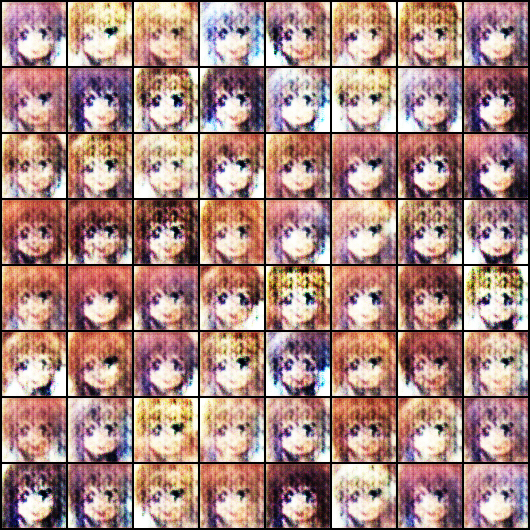

In [87]:
Image('/content/generated/generated_images - 0001.png')

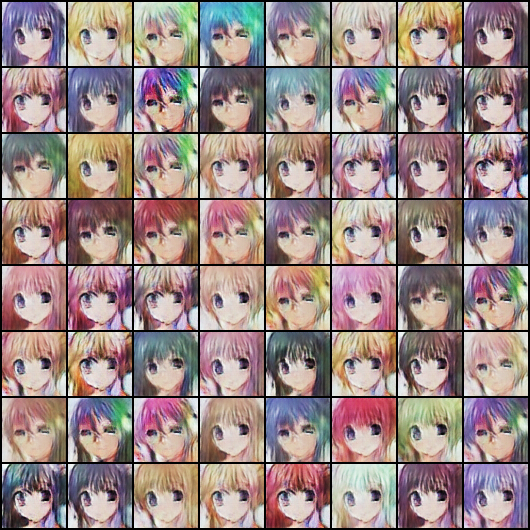

In [88]:
Image('/content/generated/generated_images - 0020.png')

In [121]:
files = [os.path.join(sample_dir,fname) for fname in os.listdir(sample_dir)]

In [122]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
cv2.destroyAllWindows()
out.release()